In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

<AxesSubplot:>

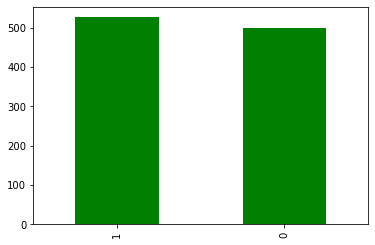

In [4]:
df['target'].value_counts().plot(kind='bar',color='green')

In [5]:
# no neeed to resapmle

In [7]:
y = df['target']
X = df.drop('target',axis=1)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [9]:
from xgboost import XGBClassifier

In [10]:
xgb = XGBClassifier()

In [11]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [12]:
grid = {
    
    'max_depth':range(3,100),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [13]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [15]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=XGBClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': range(3, 100),
                                        'min_child_weight': range(1, 20),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [16]:
best_model = xgb_random.best_estimator_

In [17]:
best_model

XGBClassifier(colsample_bytree=0.9, gamma=0.3, max_depth=78, reg_alpha=1e-05,
              subsample=0.7)

In [18]:
xgb_random.best_params_

{'subsample': 0.7,
 'reg_alpha': 1e-05,
 'min_child_weight': 1,
 'max_depth': 78,
 'gamma': 0.3,
 'colsample_bytree': 0.9}

In [19]:
xgb_random.best_score_

0.977699530516432

In [20]:
y_pred = best_model.predict(X_test)

In [21]:
err  =(y_pred- y_test)

<AxesSubplot:>

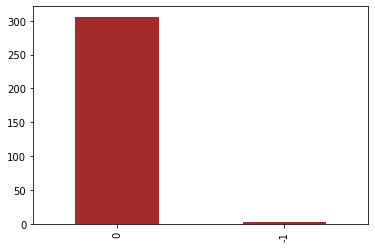

In [22]:
err.value_counts().plot(kind='bar',color='brown')

In [23]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.006493506493506494
MSE: 0.006493506493506494
RMSE: 0.08058229640253803


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[153   0]
 [  2 153]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       153
           1       1.00      0.99      0.99       155

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



In [25]:
import pickle
# open a file, where you ant to store the data
file = open('xgboost_heart_disease.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()